# Assignment 2 COMP30027: Machine Learning Semester 1 2020

Importing all the used libraries

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
import scipy
import re
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


import warnings
warnings.filterwarnings('ignore')

## Stacking Classifier class

Definition of the stacking classifier used – adapted from code used in Week 8 Practical

In [2]:
class StackingClassifier():

    def __init__(self, classifiers, metaclassifier):
        self.classifiers = classifiers
        self.metaclassifier = metaclassifier

    def fit(self, X, y):
        for clf in self.classifiers:
            clf.fit(X, y)
        X_meta = self._predict_base(X)
        self.metaclassifier.fit(X_meta, y)
    
    def _predict_base(self, X):
        yhats = []
        for clf in self.classifiers:
            yhat = clf.predict(X)
            yhats.append(yhat)
        count_y = yhats[0]
        tfidf_y = yhats[1]
        mnb_y = yhats[2]
        vector_y = []
        for i, j in zip(count_y, tfidf_y):
            vector_y.append([i,j])
        final_y = []
        for i,j in zip(vector_y, mnb_y):
            final_y.append([i[0],i[1],j])
        assert len(final_y) == X.shape[0]
        return final_y
    
    def predict(self, X):
        X_meta = self._predict_base(X)     
        yhat = self.metaclassifier.predict(X_meta)
        return yhat
    def score(self, X, y):
        yhat = self.predict(X)
        return accuracy_score(y, yhat)

## Loading of the dataset

I reloaded the dataset and did not make full use of the precomputed features as I wanted to experiment with word combinations (n-grams), since words are joined together in chains to form sentences and do not stand on it's own.

In [57]:
# For CountVectorizer
classifiers = [LogisticRegression(C = 0.25, solver = 'lbfgs', multi_class = 'multinomial'),
               LinearSVC(C = 0.05),
               MultinomialNB()]

# For TFidfVectorizer
tfidf_classifiers = [LogisticRegression(C = 100, solver = 'lbfgs', multi_class = 'multinomial'),
                     LinearSVC(C = 5),
                     MultinomialNB()]

meta_classifier = DecisionTreeClassifier()


count_stacker = StackingClassifier(classifiers, meta_classifier)
tfidf_stacker = StackingClassifier(tfidf_classifiers, meta_classifier)

# tier_1 = [count_stacker, tfidf_stacker]
# stacker = StackingClassifier(tier_1, meta_classifier)

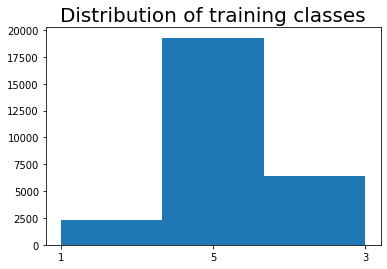

In [25]:
plt.hist(y_train, bins = 3)
plt.title('Distribution of training classes', fontsize = 20)
plt.show()

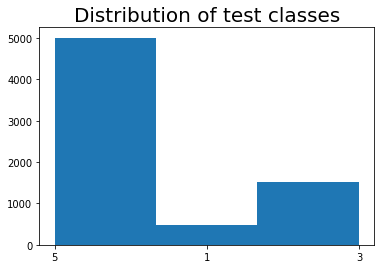

In [23]:
plt.hist(final_y['rating'], bins = 3)
plt.title('Distribution of test classes', fontsize = 20)
plt.show()

In [67]:
reviews = pd.read_csv(r"Datasets/review_text_train.csv", index_col = False, delimiter = ',', header=0)
X_train = reviews['review']

reviews_test = pd.read_csv(r"Datasets/review_text_test.csv", index_col = False, delimiter = ',', header=0)
X_test = reviews_test['review']

y_train = []
for line in open('Datasets/review_meta_train.csv', 'r'):
    y_train.append(line.strip().split(',')[-1])
y_train = y_train[1:]

final_y = {}
final_y['instance_id'] = range(1, 7019)

# Uncomment the appropriate vectorizer
# vectorizer = CountVectorizer(stop_words = 'english', ngram_range = (1, 3)).fit(X_train)
vectorizer = TfidfVectorizer(stop_words = 'english', ngram_range = (1, 3)).fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

# If wanna do feature selection
x2 = SelectKBest(chi2, k = 15000)
x2.fit(X_train,y_train)
X_train = x2.transform(X_train)
X_test = x2.transform(X_test)

# Uncomment the appropriate classifier
# classifier = LogisticRegression(C = 0.25, solver = 'lbfgs', multi_class = 'multinomial').fit(X_train, y_train)
# classifier = LinearSVC(C = 5).fit(X_train, y_train)
# classifier = count_stacker.fit(X_train, y_train)
tfidf_stacker.fit(X_train, y_train)
final_y['rating'] = tfidf_stacker.predict(X_test)
final_y = pd.DataFrame(final_y)

# Name the csv file
final_y.to_csv(r'predictions/tfidf_vectorizer_3gram_chi2_stacking.csv', index = False, header = True)

## Models experimentations:

I opted to perform a combination of various classifiers like the Zero-R(baseline), 1-R, kNN, DecisionTree, LogisticRegression, and LinearSVC, on top of altering the behaviour of the vectorizer(s) used on the reviews.

For the LogisticRegression and LinearSVC classifiers, I experimented with different values of C to determine the best value.

Alongside the CountVectorizer learned in class, I have come across another vectorizer called the TF-IDF Vectorizer (further explained in report). My research has also prompted me to test out combinations of sequences of words 
(n-grams) that appear in the review rather than just the raw counts of each word. Of course, I have tested out feature selection, but I have come to realise that the feature selection was only really effective when dealing with the raw counts of each word, without using the n-grams approach.

In [12]:
vectorizers = [CountVectorizer(stop_words='english',ngram_range=(1, 2)),
               TfidfVectorizer(stop_words='english',ngram_range=(1, 2))]

Vect = ['CountVectorizer with n-grams',
        'TfidfVectorizer with ngrams']

# models = [DummyClassifier(strategy='most_frequent'),
#           DecisionTreeClassifier(max_depth=1),
#           KNeighborsClassifier(n_neighbors=1),
#           KNeighborsClassifier(n_neighbors=5),
#           DecisionTreeClassifier(max_depth=None)]

# titles = ['0-R',
#           '1-R',
#           '1-Nearest Neighbour',
#           '5-Nearest Neighbour',
#           'Decision Tree']
    
models = []
titles = []

for c in [0.01, 0.05, 0.25, 0.5, 1.0, 5, 10, 25, 50, 100]: 

    models_with_C = [LogisticRegression(C=c, solver = 'lbfgs', multi_class = 'multinomial'),
                     LinearSVC(C=c)]
    titles_with_C = ['Logistic Regression with C = {}'.format(c),
                     'LinearSVC with C = {}'.format(c)]

    for model in models_with_C:
        models.append(model)

    for title in titles_with_C:
        titles.append(title)
        
K = 15000

In [9]:
for vec, vectorizer in zip(Vect, vectorizers):
        
    vectorizer.fit(reviews_train)
    X_train = vectorizer.transform(reviews_train)
    X_test = vectorizer.transform(reviews_test)

    x2 = SelectKBest(chi2, k=K)
    x2.fit(X_train,y_train)
    X_train_x2 = x2.transform(X_train)
    X_test_x2 = x2.transform(X_test)

    Xs = [(X_train, X_test), (X_train_x2, X_test_x2)]
    X_names = ['complete', 'x2']

    for title, model in zip(titles, models):

        print('\n',title, '(with k=',K,'features):')

        for X_name, X in zip(X_names, Xs):

            X_train_t, X_test_t = X            
            model.fit(X_train_t, y_train)
            
            acc = np.mean(cross_val_score(model, X_test_t, y_test, cv=10))
            print(X_name, '\t acc',  acc)


 Logistic Regression with C = 0.5 (with k= 25000 features):
complete 	 acc 0.8200085506626763
x2 	 acc 0.8168733076813453

 LinearSVC with C = 0.5 (with k= 25000 features):
complete 	 acc 0.857631466438649
x2 	 acc 0.854211201368106

 Logistic Regression with C = 0.5 (with k= 32500 features):
complete 	 acc 0.8200085506626763
x2 	 acc 0.8170158187259513

 LinearSVC with C = 0.5 (with k= 32500 features):
complete 	 acc 0.857631466438649
x2 	 acc 0.8539261792788941


In [33]:
# For CountVectorizer
classifiers = [LogisticRegression(C = 0.25, solver = 'lbfgs', multi_class = 'multinomial'),
               LinearSVC(C = 0.05),
               MultinomialNB()]

classifiers_titles = ['Logistic Regression with C = 0.25',
                      'LinearSVC with C = 0.05',
                      'MNB']

# For TFidfVectorizer
tfidf_classifiers = [LogisticRegression(C = 100, solver = 'lbfgs', multi_class = 'multinomial'),
                     LinearSVC(C = 5),
                     MultinomialNB()]

tfidf_classifiers_titles = ['Logistic Regression with C = 100',
                            'LinearSVC with C = 5',
                            'MNB']

meta_classifier = DecisionTreeClassifier()


count_stacker = StackingClassifier(classifiers, meta_classifier)
tfidf_stacker = StackingClassifier(tfidf_classifiers, meta_classifier)

# tier_1 = [count_stacker, tfidf_stacker]
# stacker = StackingClassifier(tier_1, meta_classifier)

In [26]:
# Using feature selection

# For CountVectorizer
reviews = pd.read_csv(r"Datasets/review_text_train.csv", index_col = False, delimiter = ',', header=0)
reviews = reviews['review']

meta_train = []
for line in open('Datasets/review_meta_train.csv', 'r'):
    meta_train.append(line.strip().split(',')[-1])
meta_train = meta_train[1:]

reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, meta_train, test_size=0.75)

vectorizer = CountVectorizer(stop_words='english',ngram_range=(1, 2)).fit(reviews_train)

X_train = vectorizer.transform(reviews_train)
X_test = vectorizer.transform(reviews_test)

x2 = SelectKBest(chi2, k=15000)
x2.fit(X_train,y_train)
X_train_x2 = x2.transform(X_train)
X_test_x2 = x2.transform(X_test)

scaler = MinMaxScaler().fit(X_train_x2.todense())
X_train_scaled = scaler.transform(X_train_x2.todense())
X_test_scaled = scaler.transform(X_test_x2.todense())

X_train_df = pd.DataFrame(X_train_scaled)
X_test_df = pd.DataFrame(X_test_scaled)

pca = PCA(n_components=2).fit(X_train_df)
X_train_df = pd.DataFrame(pca.transform(X_train_df))
X_test_df = pd.DataFrame(pca.transform(X_test_df))

SVC with linear kernel 0.8213386537456653
LinearSVC (linear kernel) 0.8207211058857061
SVC with RBF kernel 0.686380694503824
SVC with polynomial (degree 3) kernel 0.686380694503824
Using C = 0.25
SVC with linear kernel 0.8221462163317658
LinearSVC (linear kernel) 0.808037622915776
SVC with RBF kernel 0.686380694503824
SVC with polynomial (degree 3) kernel 0.686380694503824
Using C = 0.5
SVC with linear kernel 0.8175383592228398
LinearSVC (linear kernel) 0.8021946700869317
SVC with RBF kernel 0.686380694503824
SVC with polynomial (degree 3) kernel 0.686380694503824
Using C = 1
SVC with linear kernel 0.8141655978338321
LinearSVC (linear kernel) 0.7949741104935633
SVC with RBF kernel 0.686380694503824
SVC with polynomial (degree 3) kernel 0.686380694503824

## Using PCA

Using C = 0.05
Logistic Regression 0.6988741627476129
Using C = 0.25
Logistic Regression 0.6988741627476129
Using C = 0.5
Logistic Regression 0.6988741627476129
Using C = 1
Logistic Regression 0.6988741627476129


## Using C = 0.05

SVC with linear kernel 0.8213386537456653

LinearSVC (linear kernel) 0.8207211058857061

SVC with RBF kernel 0.686380694503824

SVC with polynomial (degree 3) kernel 0.686380694503824

## Using C = 0.25

SVC with linear kernel 0.8221462163317658

LinearSVC (linear kernel) 0.808037622915776

SVC with RBF kernel 0.686380694503824

SVC with polynomial (degree 3) kernel 0.686380694503824

## Using C = 0.5

SVC with linear kernel 0.8175383592228398

LinearSVC (linear kernel) 0.8021946700869317

SVC with RBF kernel 0.686380694503824

SVC with polynomial (degree 3) kernel 0.686380694503824

## Using C = 1

SVC with linear kernel 0.8141655978338321

LinearSVC (linear kernel) 0.7949741104935633

SVC with RBF kernel 0.686380694503824

SVC with polynomial (degree 3) kernel 0.686380694503824

In [37]:
count_stacker.fit(X_train_x2, y_train)
count_y = count_stacker.predict(X_test_x2)
print('\nCount Stacker Accuracy:', count_stacker.score(X_test_x2, y_test))

# For TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1, 2)).fit(reviews_train)

X_train = vectorizer.transform(reviews_train)
X_test = vectorizer.transform(reviews_test)

x2 = SelectKBest(chi2, k = 15000)
x2.fit(X_train,y_train)
X_train_x2 = x2.transform(X_train)
X_test_x2 = x2.transform(X_test)

tfidf_stacker.fit(X_train_x2, y_train)
tfidf_y = tfidf_stacker.predict(X_test_x2)
print('\nTfidf Stacker Accuracy:', tfidf_stacker.score(X_test_x2, y_test))


Count Stacker Accuracy: 0.8456605386917486

Tfidf Stacker Accuracy: 0.8496508479407154


## Visualising the data

In [36]:
reviews = pd.read_csv(r"Datasets/review_text_train.csv", index_col = False, delimiter = ',', header=0)
X_train = reviews['review']

meta_train = []
for line in open('Datasets/review_meta_train.csv', 'r'):
    meta_train.append(line.strip().split(',')[-1])
y_train = meta_train[1:]

vectorizer = CountVectorizer(stop_words='english',ngram_range=(1, 2)).fit(X_train)

X_train = vectorizer.transform(X_train)

x2 = SelectKBest(chi2, k=15000)
x2.fit(X_train,y_train)
X_train_x2 = x2.transform(X_train)

X_scaled = MinMaxScaler().fit_transform(X_train_x2.todense())

X_train_df = pd.DataFrame(X_scaled)
y_train_df = pd.DataFrame(y_train)

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train_df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, y_train_df], axis = 1)

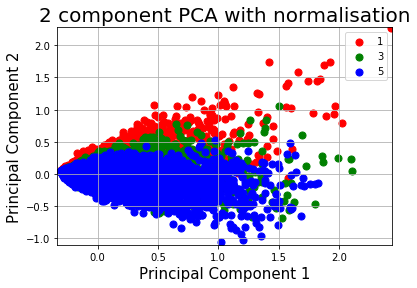

In [46]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)

ax.margins(x = 0, y = 0)
ax.set_title('2 component PCA with normalisation', fontsize = 20)
targets = ['1', '3', '5']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = y_train_df[0] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [37]:
reviews = pd.read_csv(r"Datasets/review_text_train.csv", index_col = False, delimiter = ',', header=0)
X_train = reviews['review']

meta_train = []
for line in open('Datasets/review_meta_train.csv', 'r'):
    meta_train.append(line.strip().split(',')[-1])
y_train = meta_train[1:]

vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2)).fit(X_train)
X_train = vectorizer.transform(X_train)
cv = LogisticRegression(C = 0.25, solver = 'lbfgs', multi_class = 'multinomial').fit(X_train, y_train)
feature_to_coef = {
    word: coef for word, coef in zip(
        vectorizer.get_feature_names(), cv.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
    
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)

('rude', 1.2961872557648613)
('worst', 1.247566984953104)
('horrible', 1.003438002381894)
('terrible', 0.9661706389561087)
('awful', 0.9609613247479718)
('delicious', -1.000463073717848)
('amazing', -0.8923781680537956)
('awesome', -0.7783689025231263)
('excellent', -0.7207425181624981)
('best', -0.6766377937816387)


# Using 1 tier stacking

Count Stacker Accuracy: 0.8506484252529571

Tfidf Stacker Accuracy: 0.860909220464586

# Using 1 tier stacking with feature selection

Count Stacker Accuracy: 0.8456605386917486

Tfidf Stacker Accuracy: 0.8496508479407154



MNB (with k= 7500 features):
complete 	 acc 0.6837679920193815
x2 	 acc 0.6846230582870172

 Logistic Regression with C = 0.5 (with k= 7500 features):
complete 	 acc 0.8200085506626763
x2 	 acc 0.8161607524583155

 LinearSVC with C = 0.5 (with k= 7500 features):
complete 	 acc 0.857631466438649
x2 	 acc 0.850933447342169

 MNB (with k= 10000 features):
complete 	 acc 0.6837679920193815
x2 	 acc 0.6844805472424113

 Logistic Regression with C = 0.5 (with k= 10000 features):
complete 	 acc 0.8200085506626763
x2 	 acc 0.8171583297705572

 LinearSVC with C = 0.5 (with k= 10000 features):
complete 	 acc 0.857631466438649
x2 	 acc 0.8522160467436226

 MNB (with k= 12500 features):
complete 	 acc 0.6837679920193815
x2 	 acc 0.6840530141085934

 Logistic Regression with C = 0.5 (with k= 12500 features):
complete 	 acc 0.8200085506626763
x2 	 acc 0.8173008408151632

 LinearSVC with C = 0.5 (with k= 12500 features):
complete 	 acc 0.857631466438649
x2 	 acc 0.8530711130112584

 MNB (with k= 15000 features):
complete 	 acc 0.6837679920193815
x2 	 acc 0.6839105030639875

 Logistic Regression with C = 0.5 (with k= 15000 features):
complete 	 acc 0.8200085506626763
x2 	 acc 0.818013396038193

 LinearSVC with C = 0.5 (with k= 15000 features):
complete 	 acc 0.857631466438649
x2 	 acc 0.8522160467436226

 MNB (with k= 17500 features):
complete 	 acc 0.6837679920193815
x2 	 acc 0.6837679920193815

 Logistic Regression with C = 0.5 (with k= 17500 features):
complete 	 acc 0.8200085506626763
x2 	 acc 0.8167307966367393

 LinearSVC with C = 0.5 (with k= 17500 features):
complete 	 acc 0.857631466438649
x2 	 acc 0.8527860909220465

 Logistic Regression with C = 0.5 (with k= 25000 features):
complete 	 acc 0.8200085506626763
x2 	 acc 0.8168733076813453

 LinearSVC with C = 0.5 (with k= 25000 features):
complete 	 acc 0.857631466438649
x2 	 acc 0.854211201368106

 Logistic Regression with C = 0.5 (with k= 32500 features):
complete 	 acc 0.8200085506626763
x2 	 acc 0.8170158187259513

 LinearSVC with C = 0.5 (with k= 32500 features):
complete 	 acc 0.857631466438649
x2 	 acc 0.8539261792788941

# With feature selection

MNB (with k= 7500 features):
complete 	 acc 0.6901809890266496
x2 	 acc 0.6923186546957389

 Logistic Regression with C = 0.5 (with k= 7500 features):
complete 	 acc 0.8231437936440074
x2 	 acc 0.8187259512612227

 LinearSVC with C = 0.5 (with k= 7500 features):
complete 	 acc 0.8616217756876158
x2 	 acc 0.8547812455465299

 Logistic Regression with C = 1 (with k= 7500 features):
complete 	 acc 0.844092917201083
x2 	 acc 0.837679920193815

 LinearSVC with C = 1 (with k= 7500 features):
complete 	 acc 0.8646145076243409
x2 	 acc 0.8589140658401027

 Logistic Regression with C = 5 (with k= 7500 features):
complete 	 acc 0.8613367535984039
x2 	 acc 0.8573464443494371

 LinearSVC with C = 5 (with k= 7500 features):
complete 	 acc 0.8653270628473707
x2 	 acc 0.8597691321077383

 Logistic Regression with C = 10 (with k= 7500 features):
complete 	 acc 0.8623343309106456
x2 	 acc 0.8617642867322217

 LinearSVC with C = 10 (with k= 7500 features):
complete 	 acc 0.864471996579735
x2 	 acc 0.8564913780818013

 Logistic Regression with C = 25 (with k= 7500 features):
complete 	 acc 0.864329485535129
x2 	 acc 0.8630468861336753

 LinearSVC with C = 25 (with k= 7500 features):
complete 	 acc 0.864329485535129
x2 	 acc 0.8499358700299273

 Logistic Regression with C = 50 (with k= 7500 features):
complete 	 acc 0.8634744192674932
x2 	 acc 0.8613367535984039

 LinearSVC with C = 50 (with k= 7500 features):
complete 	 acc 0.8639019524013111
x2 	 acc 0.8459455607809605

 Logistic Regression with C = 75 (with k= 7500 features):
complete 	 acc 0.864329485535129
x2 	 acc 0.8614792646430098

 LinearSVC with C = 75 (with k= 7500 features):
complete 	 acc 0.8630468861336753
x2 	 acc 0.8415277183981759

 Logistic Regression with C = 100 (with k= 7500 features):
complete 	 acc 0.8651845518027648
x2 	 acc 0.86076670941998

 LinearSVC with C = 100 (with k= 7500 features):
complete 	 acc 0.8624768419552515
x2 	 acc 0.8399600969075103

 MNB (with k= 10000 features):
complete 	 acc 0.6901809890266496
x2 	 acc 0.6916060994727091

 Logistic Regression with C = 0.5 (with k= 10000 features):
complete 	 acc 0.8231437936440074
x2 	 acc 0.8182984181274049

 LinearSVC with C = 0.5 (with k= 10000 features):
complete 	 acc 0.8616217756876158
x2 	 acc 0.8534986461450762

 Logistic Regression with C = 1 (with k= 10000 features):
complete 	 acc 0.844092917201083
x2 	 acc 0.8373948981046031

 LinearSVC with C = 1 (with k= 10000 features):
complete 	 acc 0.8646145076243409
x2 	 acc 0.8591990879293145

 Logistic Regression with C = 5 (with k= 10000 features):
complete 	 acc 0.8613367535984039
x2 	 acc 0.8570614222602252

 LinearSVC with C = 5 (with k= 10000 features):
complete 	 acc 0.8653270628473707
x2 	 acc 0.8582015106170728

 Logistic Regression with C = 10 (with k= 10000 features):
complete 	 acc 0.8623343309106456
x2 	 acc 0.8601966652415562

 LinearSVC with C = 10 (with k= 10000 features):
complete 	 acc 0.864471996579735
x2 	 acc 0.8570614222602252

 Logistic Regression with C = 25 (with k= 10000 features):
complete 	 acc 0.864329485535129
x2 	 acc 0.8630468861336753

 LinearSVC with C = 25 (with k= 10000 features):
complete 	 acc 0.864329485535129
x2 	 acc 0.8487957816730797

 Logistic Regression with C = 50 (with k= 10000 features):
complete 	 acc 0.8634744192674932
x2 	 acc 0.8626193529998575

 LinearSVC with C = 50 (with k= 10000 features):
complete 	 acc 0.8639019524013111
x2 	 acc 0.8433803619780533

 Logistic Regression with C = 75 (with k= 10000 features):
complete 	 acc 0.864329485535129
x2 	 acc 0.8596266210631324

 LinearSVC with C = 75 (with k= 10000 features):
complete 	 acc 0.8630468861336753
x2 	 acc 0.8423827846658116

 Logistic Regression with C = 100 (with k= 10000 features):
complete 	 acc 0.8651845518027648
x2 	 acc 0.8597691321077383

 LinearSVC with C = 100 (with k= 10000 features):
complete 	 acc 0.8624768419552515
x2 	 acc 0.8403876300413282

# Without feature selection

### Using CountVectorizer

0-R : Training Acc 0.6864757018668947

1-R : Training Acc 0.6980190964799772

1-Nearest Neighbour : Training Acc 0.6846230582870172

5-Nearest Neighbour : Training Acc 0.7089924469146359

Decision Tree : Training Acc 0.705287159754881

Logistic Regression with C = 0.01 : Training Acc 0.8301268348296993

LinearSVC with C = 0.01 : Training Acc 0.8475131822716261

Logistic Regression with C = 0.05 : Training Acc 0.8505059142083512

LinearSVC with C = 0.05 : Training Acc 0.8453755166025367

Logistic Regression with C = 0.25 : Training Acc 0.8486532706284737

LinearSVC with C = 0.25 : Training Acc 0.8314094342311529

Logistic Regression with C = 0.5 : Training Acc 0.8453755166025367

LinearSVC with C = 0.5 : Training Acc 0.8238563488670372

Logistic Regression with C = 1 : Training Acc 0.8436653840672652

LinearSVC with C = 1 : Training Acc 0.8197235285734644



### Using CountVectorizer with n-grams

0-R : Training Acc 0.6864757018668947

1-R : Training Acc 0.6980190964799772

1-Nearest Neighbour : Training Acc 0.6836254809747755

5-Nearest Neighbour : Training Acc 0.6948838534986461

Decision Tree : Training Acc 0.7235285734644435

Logistic Regression with C = 0.01 : Training Acc 0.8352572324355138

LinearSVC with C = 0.01 : Training Acc 0.8537836682342882

Logistic Regression with C = 0.05 : Training Acc 0.8544962234573179

LinearSVC with C = 0.05 : Training Acc 0.8553512897249537

Logistic Regression with C = 0.25 : Training Acc 0.8606241983753741

LinearSVC with C = 0.25 : Training Acc 0.8499358700299273

Logistic Regression with C = 0.5 : Training Acc 0.8620493088214337

LinearSVC with C = 0.5 : Training Acc 0.8470856491378081

Logistic Regression with C = 1 : Training Acc 0.860909220464586

LinearSVC with C = 1 : Training Acc 0.8439504061564771



### Using TfidfVectorizer

0-R : Training Acc 0.6864757018668947

1-R : Training Acc 0.6978765854353712

1-Nearest Neighbour : Training Acc 0.6849080803762292

5-Nearest Neighbour : Training Acc 0.7159754881003277

Decision Tree : Training Acc 0.7047171155764572

Logistic Regression with C = 0.01 : Training Acc 0.6863331908222887

LinearSVC with C = 0.01 : Training Acc 0.741769987174006

Logistic Regression with C = 0.05 : Training Acc 0.7409149209063702

LinearSVC with C = 0.05 : Training Acc 0.8291292575174576

Logistic Regression with C = 0.25 : Training Acc 0.8251389482684908

LinearSVC with C = 0.25 : Training Acc 0.8519310246544107

Logistic Regression with C = 0.5 : Training Acc 0.841242696308964

LinearSVC with C = 0.5 : Training Acc 0.8516460025651988

Logistic Regression with C = 1 : Training Acc 0.8505059142083512

LinearSVC with C = 1 : Training Acc 0.8448054724241129



### Using TfidfVectorizer with ngrams

0-R : Training Acc 0.6864757018668947

1-R : Training Acc 0.6978765854353712

1-Nearest Neighbour : Training Acc 0.6864757018668947

5-Nearest Neighbour : Training Acc 0.7161179991449337

Decision Tree : Training Acc 0.7062847370671227

Logistic Regression with C = 0.01 : Training Acc 0.6864757018668947

LinearSVC with C = 0.01 : Training Acc 0.6897534558928317

Logistic Regression with C = 0.05 : Training Acc 0.6904660111158615

LinearSVC with C = 0.05 : Training Acc 0.7997719823286304

Logistic Regression with C = 0.25 : Training Acc 0.7933589853213624

LinearSVC with C = 0.25 : Training Acc 0.8534986461450762

Logistic Regression with C = 0.5 : Training Acc 0.8255664814023087

LinearSVC with C = 0.5 : Training Acc 0.8597691321077383

Logistic Regression with C = 1 : Training Acc 0.8439504061564771

LinearSVC with C = 1 : Training Acc 0.8639019524013111


In [21]:
feature_to_coef = {
    word: coef for word, coef in zip(
        ngram_vectorizer.get_feature_names(), final_model.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
    
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)


('rude', 1.2419884655366749)
('worst', 1.189477580476503)
('terrible', 0.9816836278499985)
('overpriced', 0.9619470822144517)
('horrible', 0.9346316907284365)
('delicious', -0.9538910492530771)
('amazing', -0.832934851492662)
('awesome', -0.7057677171085484)
('excellent', -0.6301429429540839)
('best', -0.6245928513095459)


### Acknowledgement:

References:

Mukherjee, A., Venkataraman, V., Liu, B. & Glance, N. What Yelp fake review filter might be doing?  7th International AAAI Conference on Weblogs and Social Media, 2013.

Rayana, S. & Akoglu, L. Collective opinion spam detection: Bridging review networks and metadata.  Proceedings of the 21th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015. 985-994.


Parts of the code was adapted from the following websites to suit the assignment:

https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184

https://towardsdatascience.com/sentiment-analysis-with-python-part-2-4f71e7bde59a